ref: https://github.com/fastai/fastai_docs/blob/master/dev_course/dl2/audio.ipynb

In [149]:
from fastai.vision import *
import torchaudio
from torchaudio import transforms 

### nb exporter

In [71]:
#export 
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

### data

In [2]:
path = Path("../data/fat19")

In [3]:
path.ls()

[PosixPath('../data/fat19/train_curated'),
 PosixPath('../data/fat19/sample_submission.csv'),
 PosixPath('../data/fat19/train_noisy.csv'),
 PosixPath('../data/fat19/train_curated.csv'),
 PosixPath('../data/fat19/test'),
 PosixPath('../data/fat19/train_noisy')]

In [4]:
TRAIN_CURATED = path/"train_curated"
TRAIN_NOISY = path/"train_noisy"
TEST = path/"test"

In [6]:
train_curated_files = get_files(TRAIN_CURATED, extensions=".wav")
train_noisy_files = get_files(TRAIN_NOISY, extensions=".wav")
test_files = get_files(TEST, extensions=".wav")

In [7]:
len(train_curated_files), len(train_noisy_files), len(test_files)

(4970, 19815, 1120)

In [8]:
train_curated_df = pd.read_csv(path/"train_curated.csv")
train_noisy_df = pd.read_csv(path/"train_noisy.csv")

In [9]:
len(train_curated_df), len(train_noisy_df)

(4970, 19815)

In [20]:
curated_labels = Counter(train_curated_df.labels.apply(lambda x: x.split(",")).sum())
noisy_labels = Counter(train_noisy_df.labels.apply(lambda x: x.split(",")).sum())

In [22]:
curated_labels, noisy_labels

(Counter({'Bark': 75,
          'Raindrop': 75,
          'Finger_snapping': 75,
          'Run': 75,
          'Whispering': 75,
          'Acoustic_guitar': 75,
          'Strum': 75,
          'Hi-hat': 75,
          'Bass_drum': 75,
          'Crowd': 75,
          'Cheering': 75,
          'Frying_(food)': 63,
          'Chewing_and_mastication': 75,
          'Fart': 75,
          'Bass_guitar': 75,
          'Knock': 75,
          'Motorcycle': 75,
          'Stream': 75,
          'Male_singing': 75,
          'Crackle': 75,
          'Sigh': 57,
          'Burping_and_eructation': 75,
          'Female_singing': 75,
          'Tap': 75,
          'Female_speech_and_woman_speaking': 75,
          'Accelerating_and_revving_and_vroom': 75,
          'Clapping': 75,
          'Accordion': 47,
          'Zipper_(clothing)': 75,
          'Bus': 75,
          'Meow': 75,
          'Waves_and_surf': 75,
          'Microwave_oven': 75,
          'Child_speech_and_kid_speaking': 75,
  

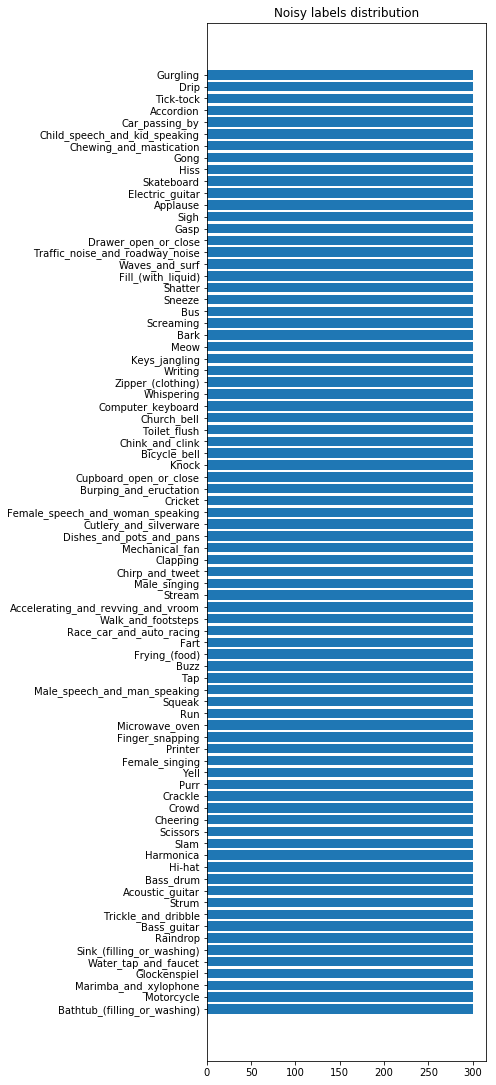

In [59]:
# fig, ax = plt.subplots(1,1,figsize=(10,20))
label_count = sorted(list(noisy_labels.items()), key=lambda x: x[1], reverse=False)
labels, counts = list(zip(*label_count))
fig, ax = plt.subplots(1,1,figsize=(7,15))
ax.barh(labels, counts);fig.tight_layout(); ax.set_title("Noisy labels distribution");

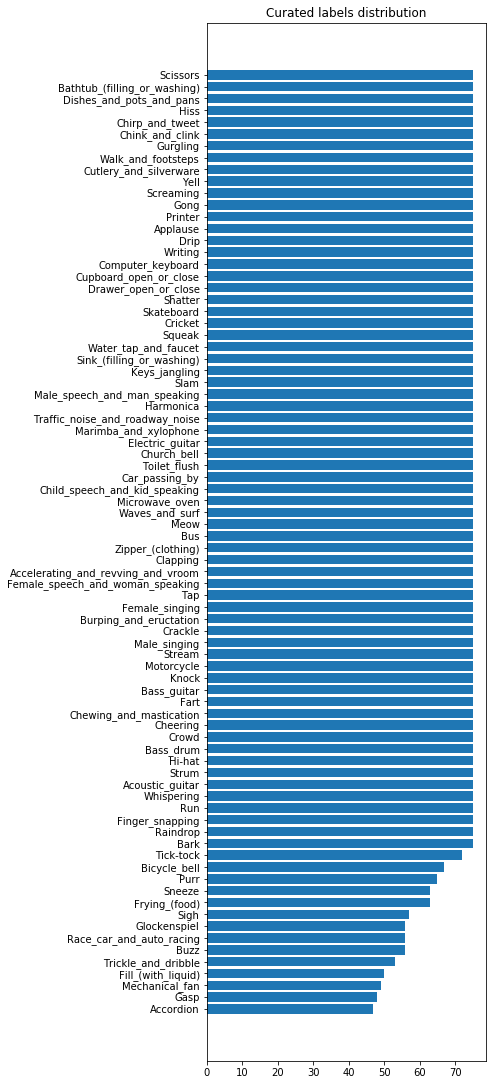

In [58]:
label_count = sorted(list(curated_labels.items()), key=lambda x: x[1], reverse=False)
labels, counts = list(zip(*label_count))
fig, ax = plt.subplots(1,1,figsize=(7,15))
ax.barh(labels, counts);fig.tight_layout(); ax.set_title("Curated labels distribution");

In [64]:
if set(noisy_labels.keys()) == set(curated_labels.keys()) : print("Same label set in noisy and curated")

Same label set in noisy and curated


### Audio List

A media type (also known as a Multipurpose Internet Mail Extensions or MIME type) is a standard that indicates the nature and format of a document, file, or assortment of bytes.

In [67]:
AUDIO_EXTS = {str.lower(k) for k,v in mimetypes.types_map.items() if v.startswith('audio/')}

In [68]:
AUDIO_EXTS

{'.aif', '.aifc', '.aiff', '.au', '.mp2', '.mp3', '.ra', '.snd', '.wav'}

In [230]:
#export
class AudioList(ItemList):
    def __init__(self, *args, **kwargs):
        self.msecs={}       # clips in milliseconds  
        super().__init__(*args, **kwargs)
    
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = AUDIO_EXTS
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, i):
        fn = self.path/self.items[i]
        sig, sr = torchaudio.load(fn)
        assert sig.size(0) == 1, "Non-mono audio detected, mono only supported for now."
        self.msecs[self.items[i]] = sig.size(1)/sr*1000
        
        return (sig, sr)

In [231]:
train_noisy_df.head()

fname                                          labels
0  00097e21.wav                    Bathtub_(filling_or_washing)
1  000b6cfb.wav                                      Motorcycle
2  00116cd2.wav              Marimba_and_xylophone,Glockenspiel
3  00127d14.wav  Water_tap_and_faucet,Sink_(filling_or_washing)
4  0019adae.wav                                        Raindrop

In [232]:
path/"train_noisy"

PosixPath('../data/fat19/train_noisy')

In [233]:
il = AudioList.from_df(train_noisy_df, path=path/"train_noisy")

In [234]:
il

AudioList (19815 items)
(tensor([[-0.0022, -0.0028, -0.0027,  ..., -0.0154, -0.0108, -0.0083]]), 44100),(tensor([[-0.2090, -0.2009, -0.1964,  ..., -0.0299, -0.0298, -0.0293]]), 44100),(tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0685, -0.0747, -0.0803]]), 44100),(tensor([[-0.0064, -0.0034,  0.0011,  ...,  0.0663, -0.0686, -0.0721]]), 44100),(tensor([[0.0092, 0.0141, 0.0182,  ..., 0.0293, 0.0362, 0.0448]]), 44100)
Path: ../data/fat19/train_noisy

In [236]:
il[0]

(tensor([[-0.0022, -0.0028, -0.0027,  ..., -0.0154, -0.0108, -0.0083]]), 44100)

In [237]:
ill = il.split_by_rand_pct(0.1)

In [238]:
ll = ill.label_from_df(label_cls=partial(MultiCategoryList, label_delim=","))

In [239]:
ll

LabelLists;

Train: LabelList (17834 items)
x: AudioList
(tensor([[-0.0022, -0.0028, -0.0027,  ..., -0.0154, -0.0108, -0.0083]]), 44100),(tensor([[-0.2090, -0.2009, -0.1964,  ..., -0.0299, -0.0298, -0.0293]]), 44100),(tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0685, -0.0747, -0.0803]]), 44100),(tensor([[-0.0064, -0.0034,  0.0011,  ...,  0.0663, -0.0686, -0.0721]]), 44100),(tensor([[0.0092, 0.0141, 0.0182,  ..., 0.0293, 0.0362, 0.0448]]), 44100)
y: MultiCategoryList
Bathtub_(filling_or_washing),Motorcycle,Marimba_and_xylophone;Glockenspiel,Water_tap_and_faucet;Sink_(filling_or_washing),Raindrop
Path: ../data/fat19/train_noisy;

Valid: LabelList (1981 items)
x: AudioList
(tensor([[-0.1234, -0.1222, -0.1197,  ...,  0.1668,  0.1675,  0.1693]]), 44100),(tensor([[ 0.0146,  0.0131,  0.0108,  ..., -0.0251, -0.0257, -0.0258]]), 44100),(tensor([[-0.0375, -0.0032,  0.0282,  ...,  0.0668,  0.0640,  0.0549]]), 44100),(tensor([[-0.0240, -0.0223, -0.0320,  ..., -0.0665, -0.0661, -0.0726]]), 44100),

**Sample rate** is the number of samples of audio carried per second, measured in Hz or kHz (one kHz being 1000 Hz). For example, 44100 samples per second can be expressed as either 44100 Hz, or 44.1 kHz. Bandwidth is the difference between the highest and lowest frequencies carried in an audio stream.

In [240]:
# what is this representing?
ll.train.x[0]

(tensor([[-0.0022, -0.0028, -0.0027,  ..., -0.0154, -0.0108, -0.0083]]), 44100)

In [241]:
ll.train.x[0][0].shape

torch.Size([1, 661500])

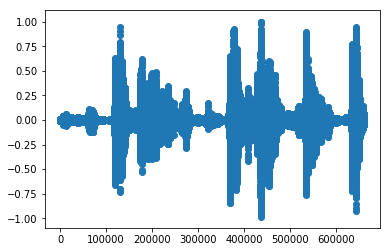

In [242]:
plt.scatter(range(ll.train.x[0][0].shape[1]), to_np(ll.train.x[0][0]))

## Transforms: audio clipping & conversion to spectrograms

The pytorch dataloader needs to be all tensors to be the same size, but our input audio files are of different sizes, so we need to trim them. Also, recall that we're not going to send the model the audio signal directly; we're going to convert it to spectrograms first. We can treat these steps as transforms. We can also apply data augmentation to both the signal and the spectrograms.

Small helpers to show some audio & compare transformed versions.

In [243]:
#export
from IPython.display import Audio
def show_audio(ad):
    sig,sr=ad
    display(Audio(data=sig, rate=sr))

In [244]:
#export
def show_audio_in_out(orig, trans):
    """Helper to plot input and output signal in different colors"""
    osig,osr = orig
    tsig,tsr = trans
    print("↓ Original ↓")
    show_audio(orig)
    print("↓ Transformed ↓")
    show_audio(trans)
    if orig is not None: plt.plot(osig[0], 'm', label="Orig.")
    if trans is not None: plt.plot(tsig[0], 'c', alpha=0.5, label="Transf.")
    plt.legend()
    plt.show()

In [245]:
#export
class PadOrTrim(Transform):
    # pads or trims based on original sample size and msecs
    _order=11
    def __init__(self,msecs=15000): self.msecs = msecs
    def __call__(self, ad): 
        sig,sr = ad # audio signal, sample rate
        mx = sr//1000 * self.msecs # number of samples
        return (transforms.PadTrim(mx)(sig), sr)

In [246]:
len(ll.train)

17834

Traffic_noise_and_roadway_noise
↓ Original ↓


↓ Transformed ↓


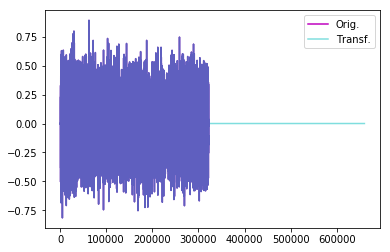

In [249]:
i = 200
print(ll.train.y[i])
pt = PadOrTrim(15000) ## duration in milliseconds
show_audio_in_out(ll.train.x[i], pt(ll.train.x[i]))

In [264]:
for i in range(len(ll.train)): ll.train.x[i]

KeyboardInterrupt: 

In [265]:
# audio length distribution
Counter(ll.msecs.values())

Counter({15000.0: 6005,
         7314.285714285714: 4,
         14117.732426303855: 2,
         15580.589569160997: 7,
         15092.97052154195: 5,
         13630.113378684808: 2,
         9009.342403628118: 5,
         6571.247165532879: 2,
         11911.836734693878: 4,
         10565.079365079366: 1,
         8080.544217687076: 2,
         10054.240362811792: 6,
         8405.62358276644: 2,
         9914.920634920636: 1,
         14349.931972789114: 4,
         7035.646258503401: 4,
         9171.8820861678: 1,
         8150.2040816326535: 1,
         11749.297052154194: 1,
         15162.630385487528: 3,
         2205.8956916099773: 1,
         10541.859410430838: 2,
         15719.909297052154: 1,
         10611.519274376418: 1,
         11633.197278911564: 2,
         12678.095238095239: 3,
         14071.292517006803: 2,
         13421.133786848071: 2,
         12051.156462585033: 6,
         10472.19954648526: 3,
         15557.369614512472: 8,
         7407.165532879819: 1

Overview. A **channel** is a representation of sound coming from or going to a single point. A single microphone can produce one channel of audio, and a single speaker can accept one channel of audio, for example. A digital audio file can contain multiple channels of data.

### Signal shifting
Signal shifting is a useful augmentation which can be applied to the signal itself; it simply shifts the input to the left or right by some %. Intuitively, this is useful for classification, but perhaps not for predictive models, as it can change the temporal order of things when the end of the signal wraps around to the front.

This implementation lightly adapted from the original implementation by Harry Coultas Blum.

In [280]:
#export
class SignalShift(Transform):
    _order=20
    def __init__(self, max_shift_pct=.6): self.max_shift_pct = max_shift_pct
    def __call__(self, ad):
        sig,sr = ad
        # torch.tensor([0,1,2,3,4]).roll(2) == torch.tensor([3, 4, 0, 1, 2])    
        roll_by = int(random.random()*self.max_shift_pct*len(sig[0]))
        return (sig.roll(roll_by), sr)

↓ Original ↓


↓ Transformed ↓


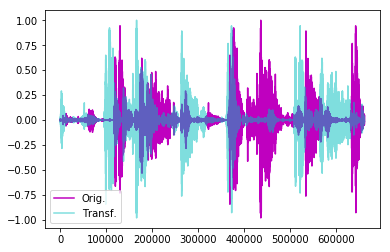

In [267]:
shifter = SignalShift()
show_audio_in_out(ll.train[0][0], shifter(ll.train[0][0]))

### Spectrogram
Once we're done augmenting the signal directly, we want to convert our 1D signal to a 2D spectrogram.

Luckily, torchaudio has functions for calculation & conversion to spectrograms. Let's wrap their functions.